In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap


from source import plot_f_3d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import lmdKANLayer, lmdKAN, importance_analyse_lmdKAN


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
-----
## Boston housing dataset

##### Boston housing dataset

In [2]:
from sklearn.preprocessing import StandardScaler
# load dataset
data = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/curated-solubility-dataset.csv"
)
x_data = data.loc[:, "MolWt":]
y_data = data["Solubility"]

n_var = x_data.shape[1]

ss_x, ss_y = StandardScaler(), StandardScaler()

x_data_scaled = ss_x.fit_transform(x_data.values)
y_data_scaled = ss_y.fit_transform(y_data.values.reshape(-1, 1))

dataset = {
    'train_input': torch.Tensor(x_data_scaled),
    'test_input': torch.Tensor(x_data_scaled),
    'train_label': torch.Tensor(y_data_scaled),
    'test_label': torch.Tensor(y_data_scaled),
}

-----
### MLP

№ model trainable params: 441


| train_loss: 4.00e-01 | test_loss: 5.32e-01 | reg: 1.71e+02 | : 100%|█| 100/100 [00:04<00:00, 24.08


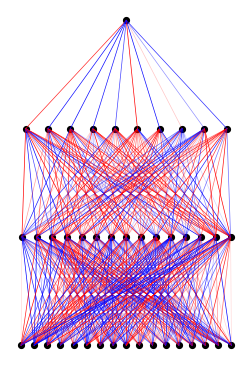

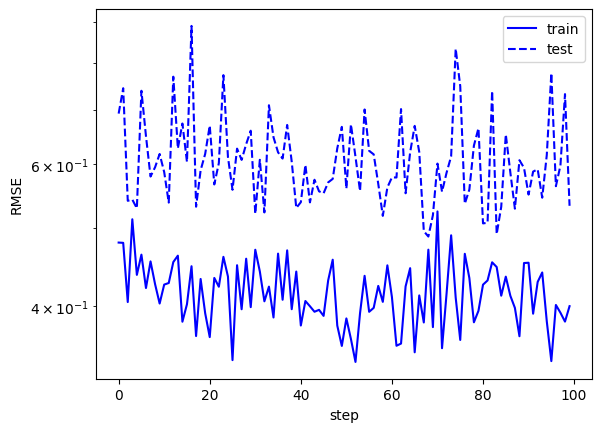

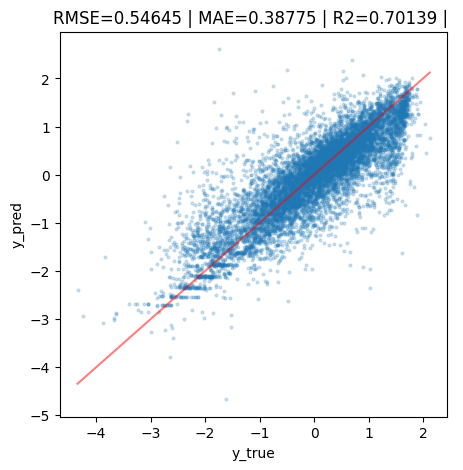

In [3]:
# initialize MLP
model = MLP(width=[n_var,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 1080


| train_loss: 3.86e-01 | test_loss: 5.66e-01 | reg: 4.07e+01 | : 100%|█| 100/100 [00:37<00:00,  2.68


saving model version 0.1


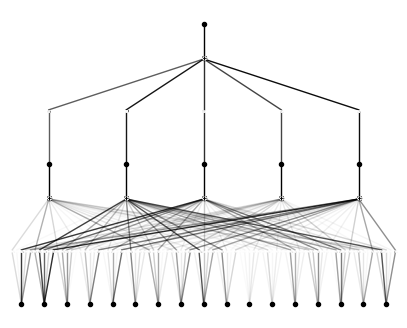

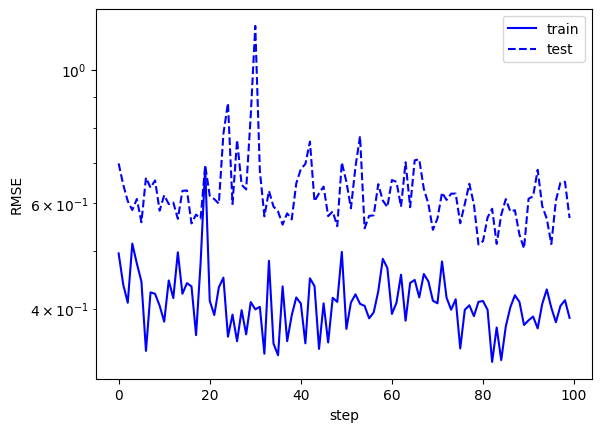

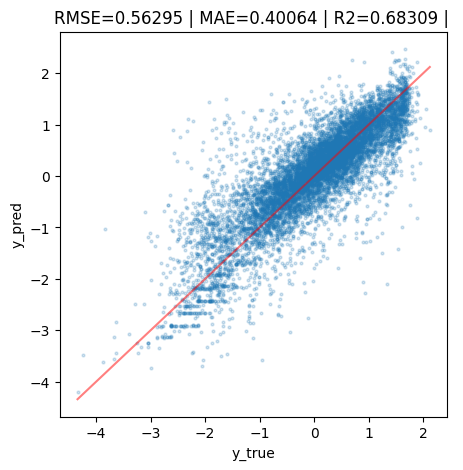

In [4]:
# initialize KAN with G=3
model = KAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### $\lambda$-KAN

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 457


| train_loss: 5.27e-01 | test_loss: 5.92e-01 | reg: 2.98e+01 | : 100%|█| 150/150 [01:05<00:00,  2.28


saving model version 0.1


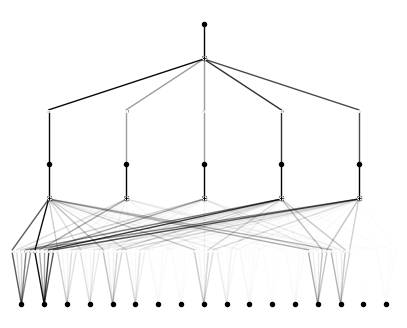

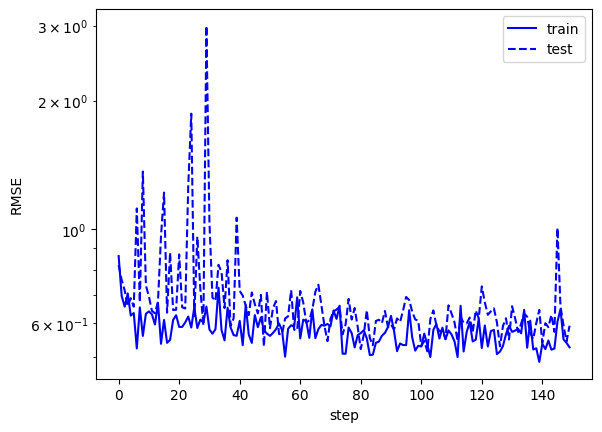

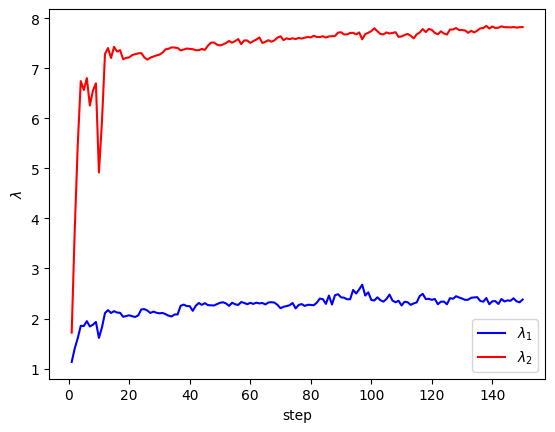

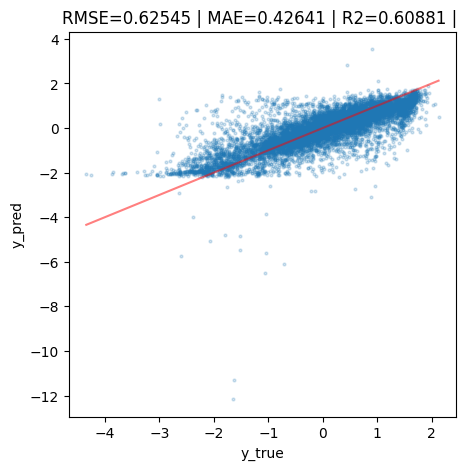

model.act_fun[0].lmd=Parameter containing:
tensor([ 2.3788,  7.8235, -0.6076, -0.3944, -0.8508, -0.4948, -0.1082, -0.0727,
        -0.6456,  0.2585, -0.1032,  0.0323, -0.0782,  1.1237,  0.9564, -0.0116,
         0.0633], requires_grad=True)


In [5]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True)
print(f'{model.act_fun[0].lmd=}')

PermutationExplainer explainer: 9983it [2:02:10,  1.36it/s]                            


module of Input importance:


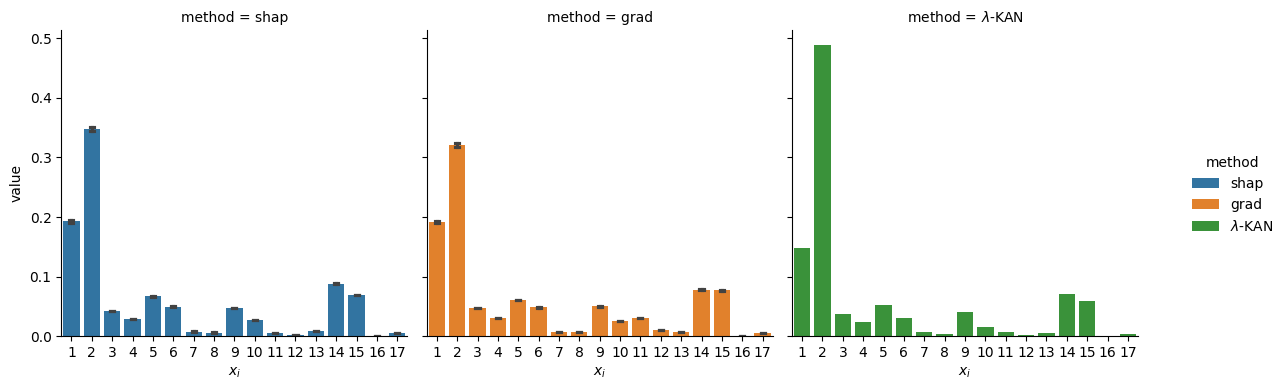

Input importance:


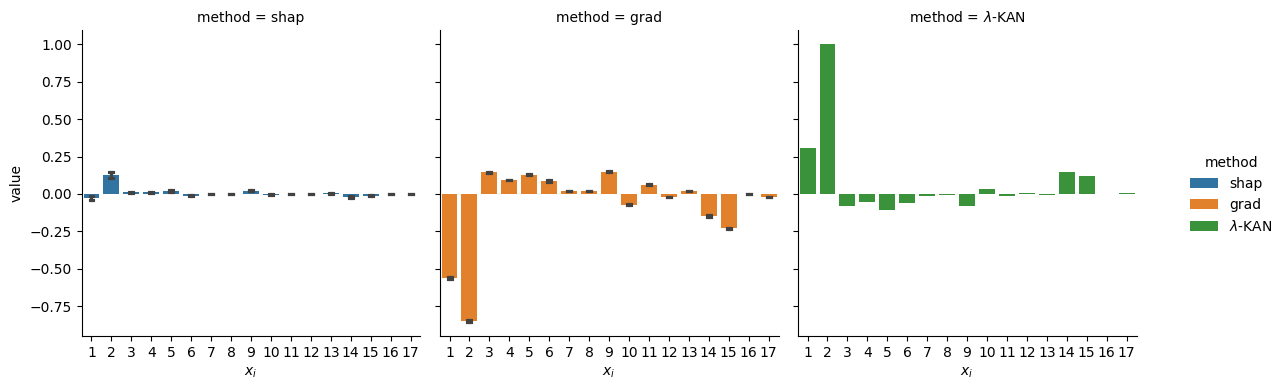

In [6]:
importance_analyse_lmdKAN(model, dataset)

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
-----
### $\lambda$-KAN with __R2 regression__ in respect to __Interm. activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 142


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 3.20e-02 | test_loss: 3.45e-02 | reg: 7.43e+00 | : 100%|█| 150/150 [02:24<00:00,  1.04


saving model version 0.1


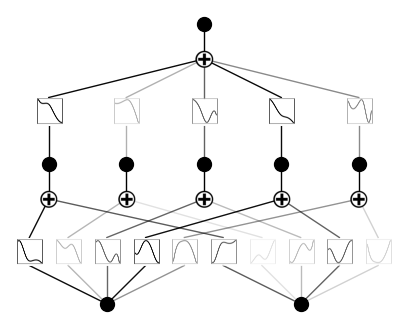

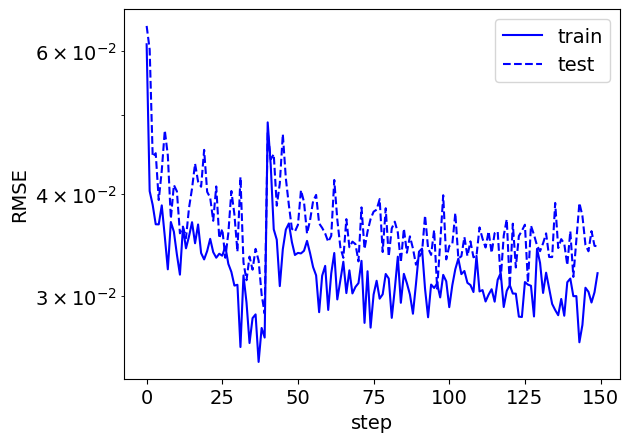

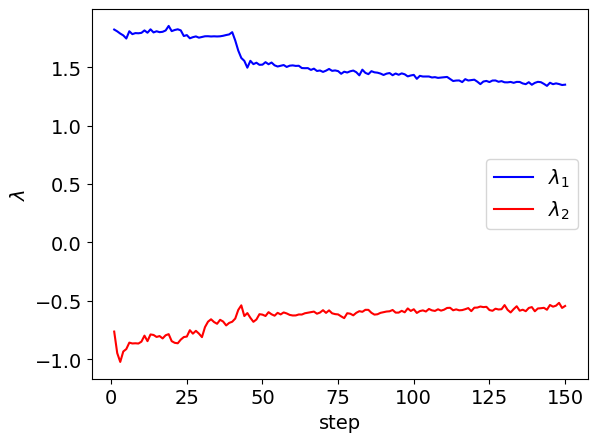

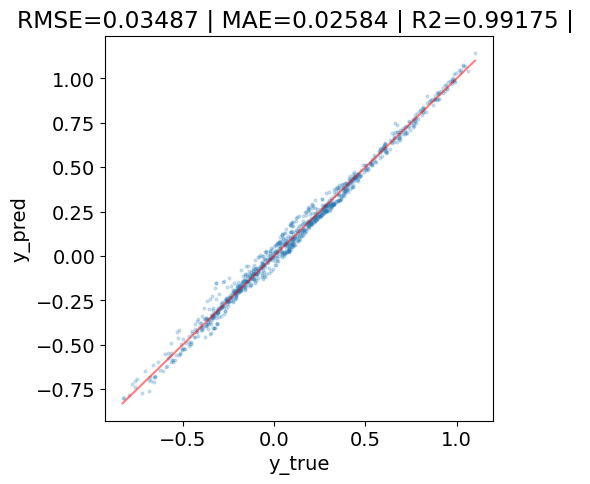

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.3509, -0.5434], requires_grad=True)


In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='r2',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:28, 21.78it/s]                         


module of Input importance:


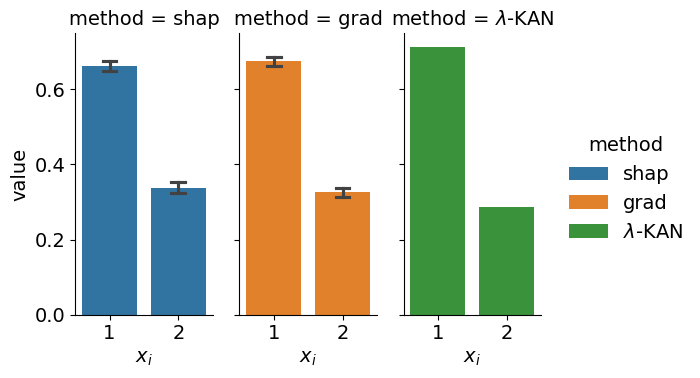

Input importance:


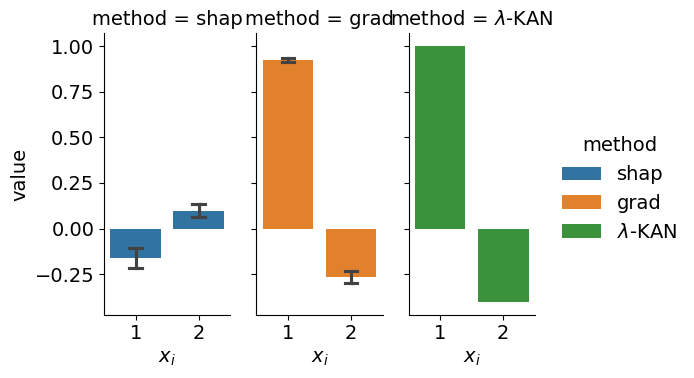

In [68]:
importance_analyse_lmdKAN(model, dataset)

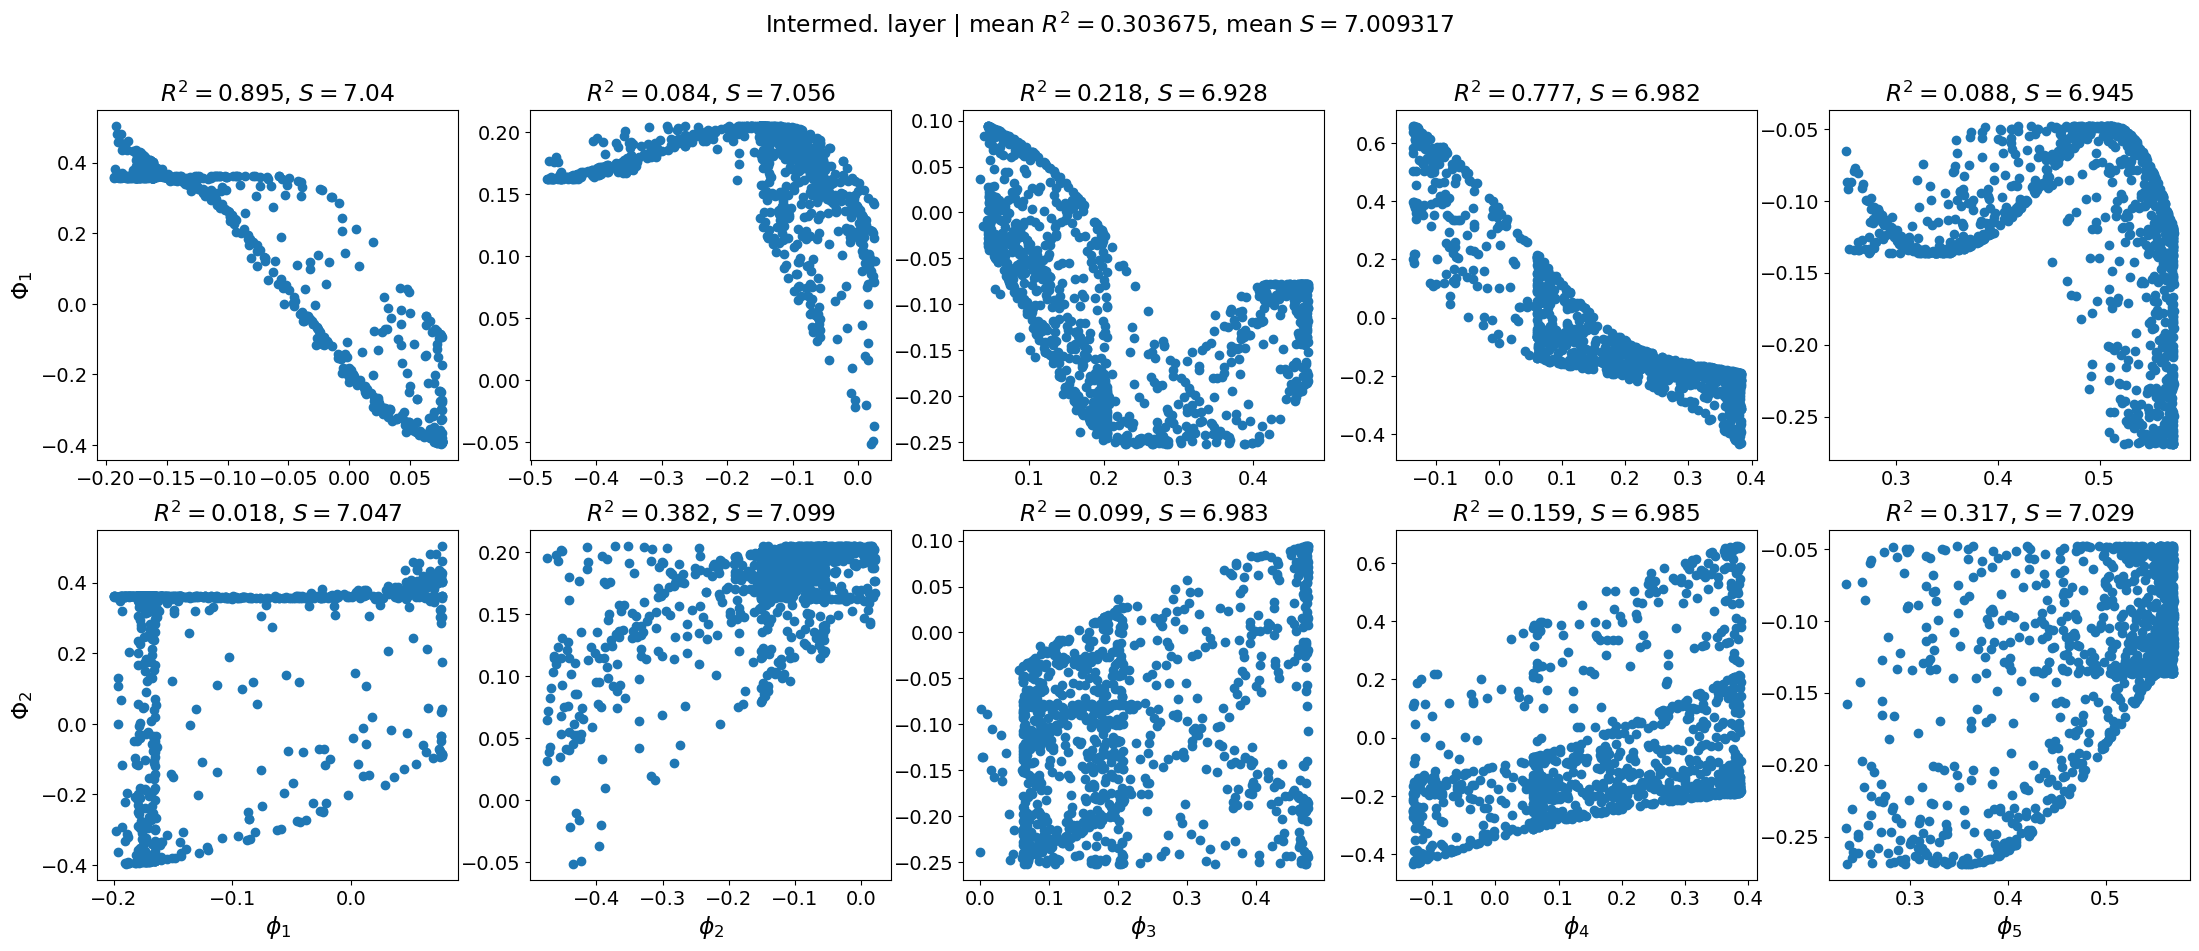

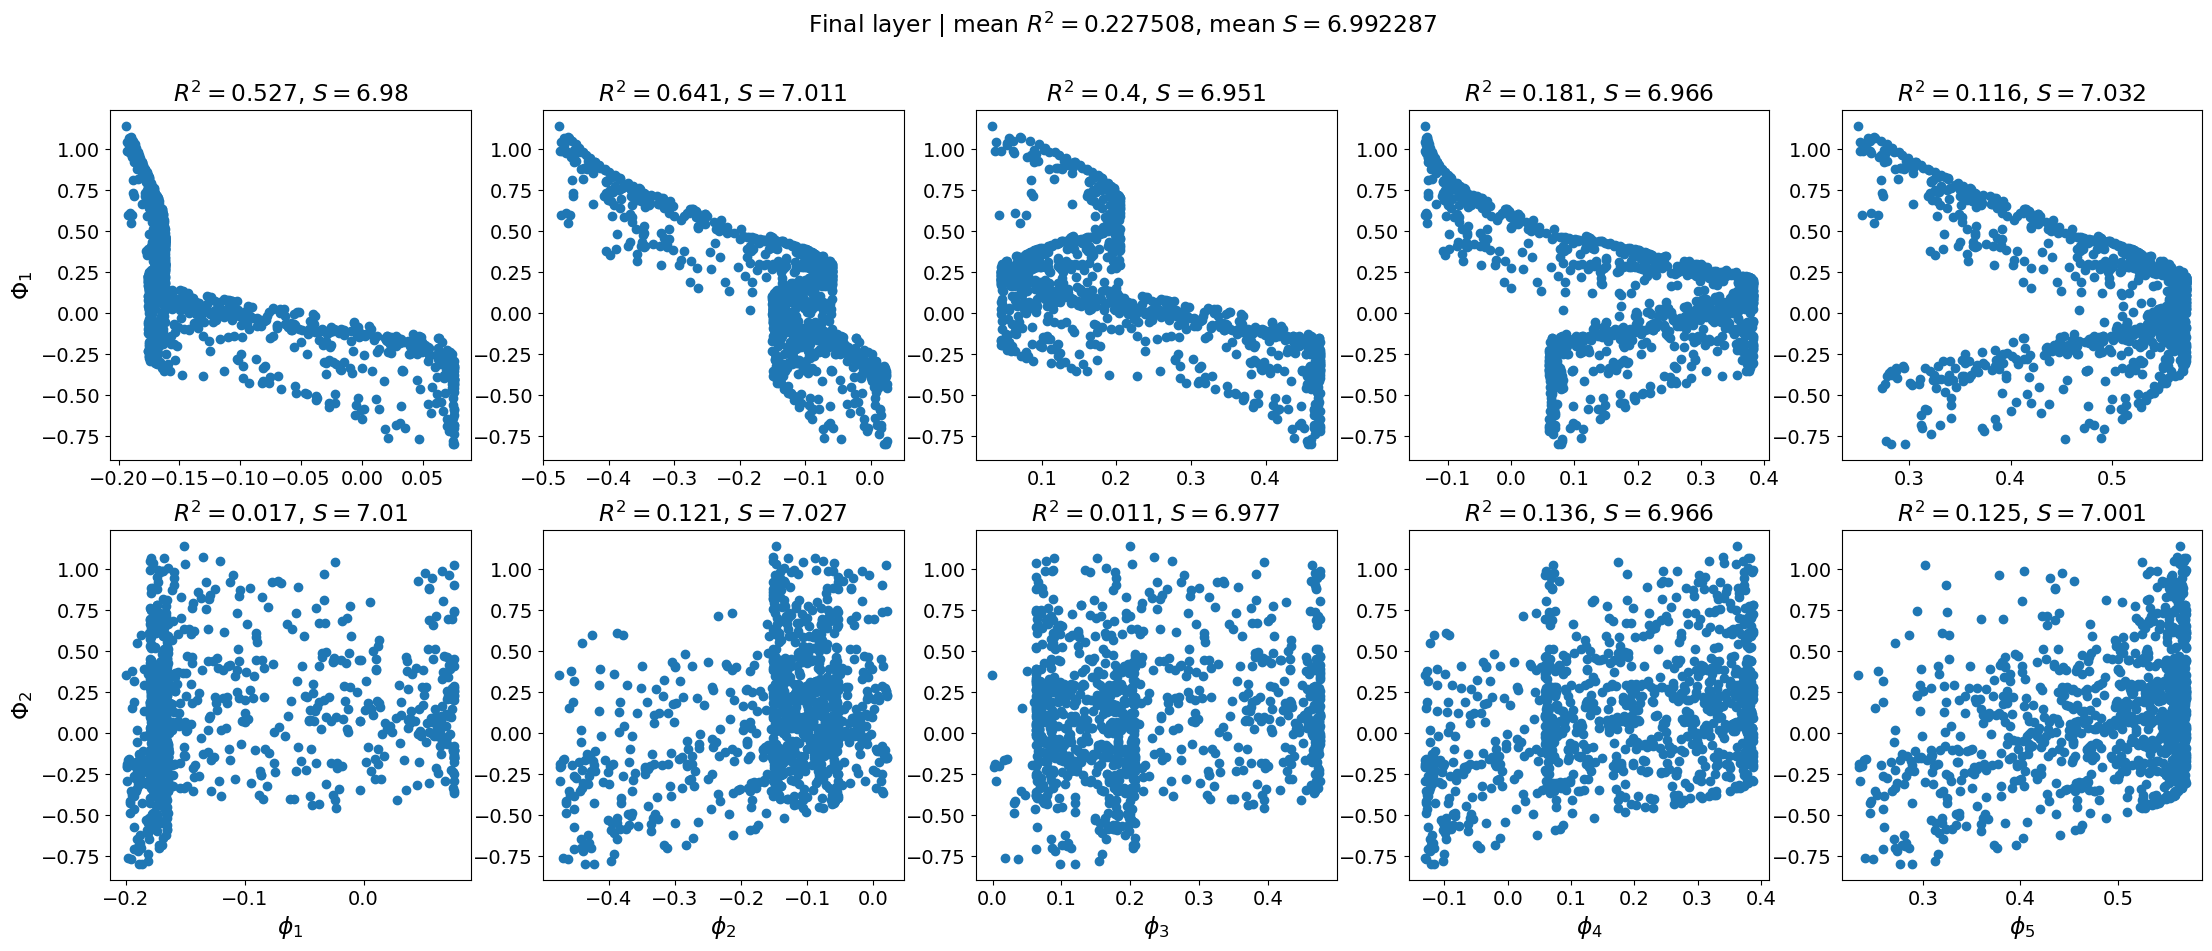

{'mean_r2': 0.22750781942158937, 'mean_matrix_entropy': 6.992286682128906}

In [69]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
### $\lambda$-KAN with __Entropy regression__ in respect to __Interm. activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 142


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 3.21e-02 | test_loss: 3.32e-02 | reg: 7.67e+00 | : 100%|█| 150/150 [02:30<00:00,  1.01


saving model version 0.1


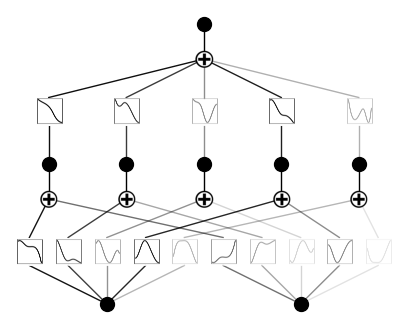

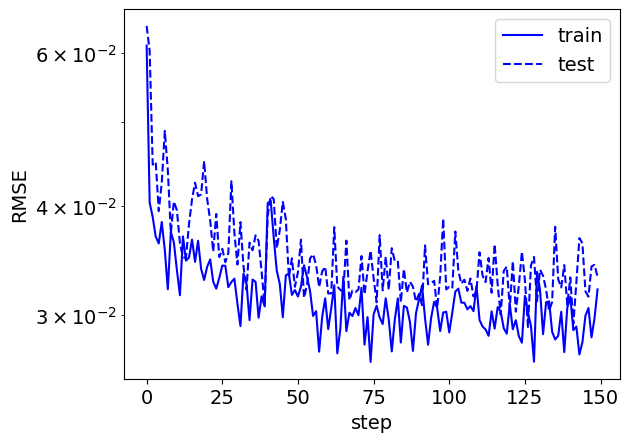

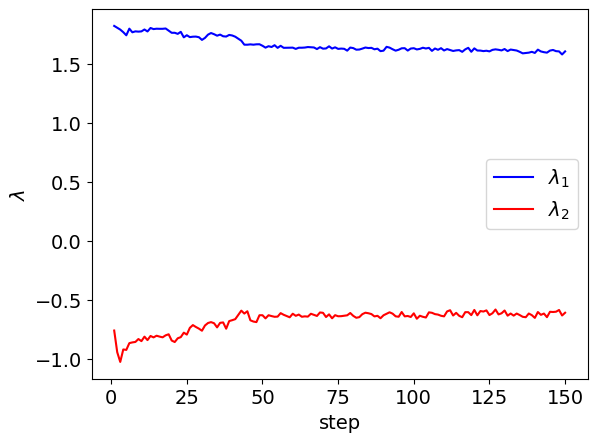

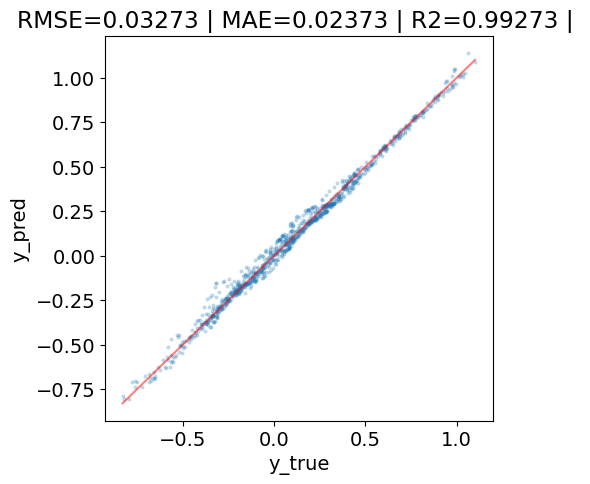

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.6066, -0.6115], requires_grad=True)


In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:20, 24.89it/s]                         


module of Input importance:


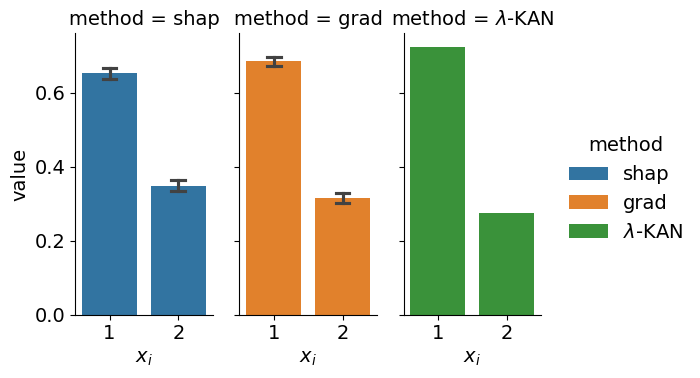

Input importance:


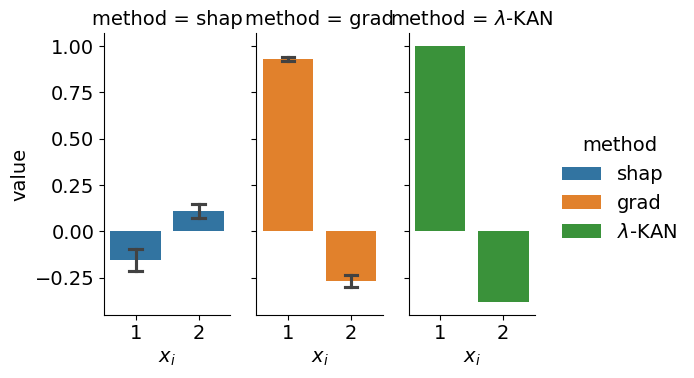

In [72]:
importance_analyse_lmdKAN(model, dataset)

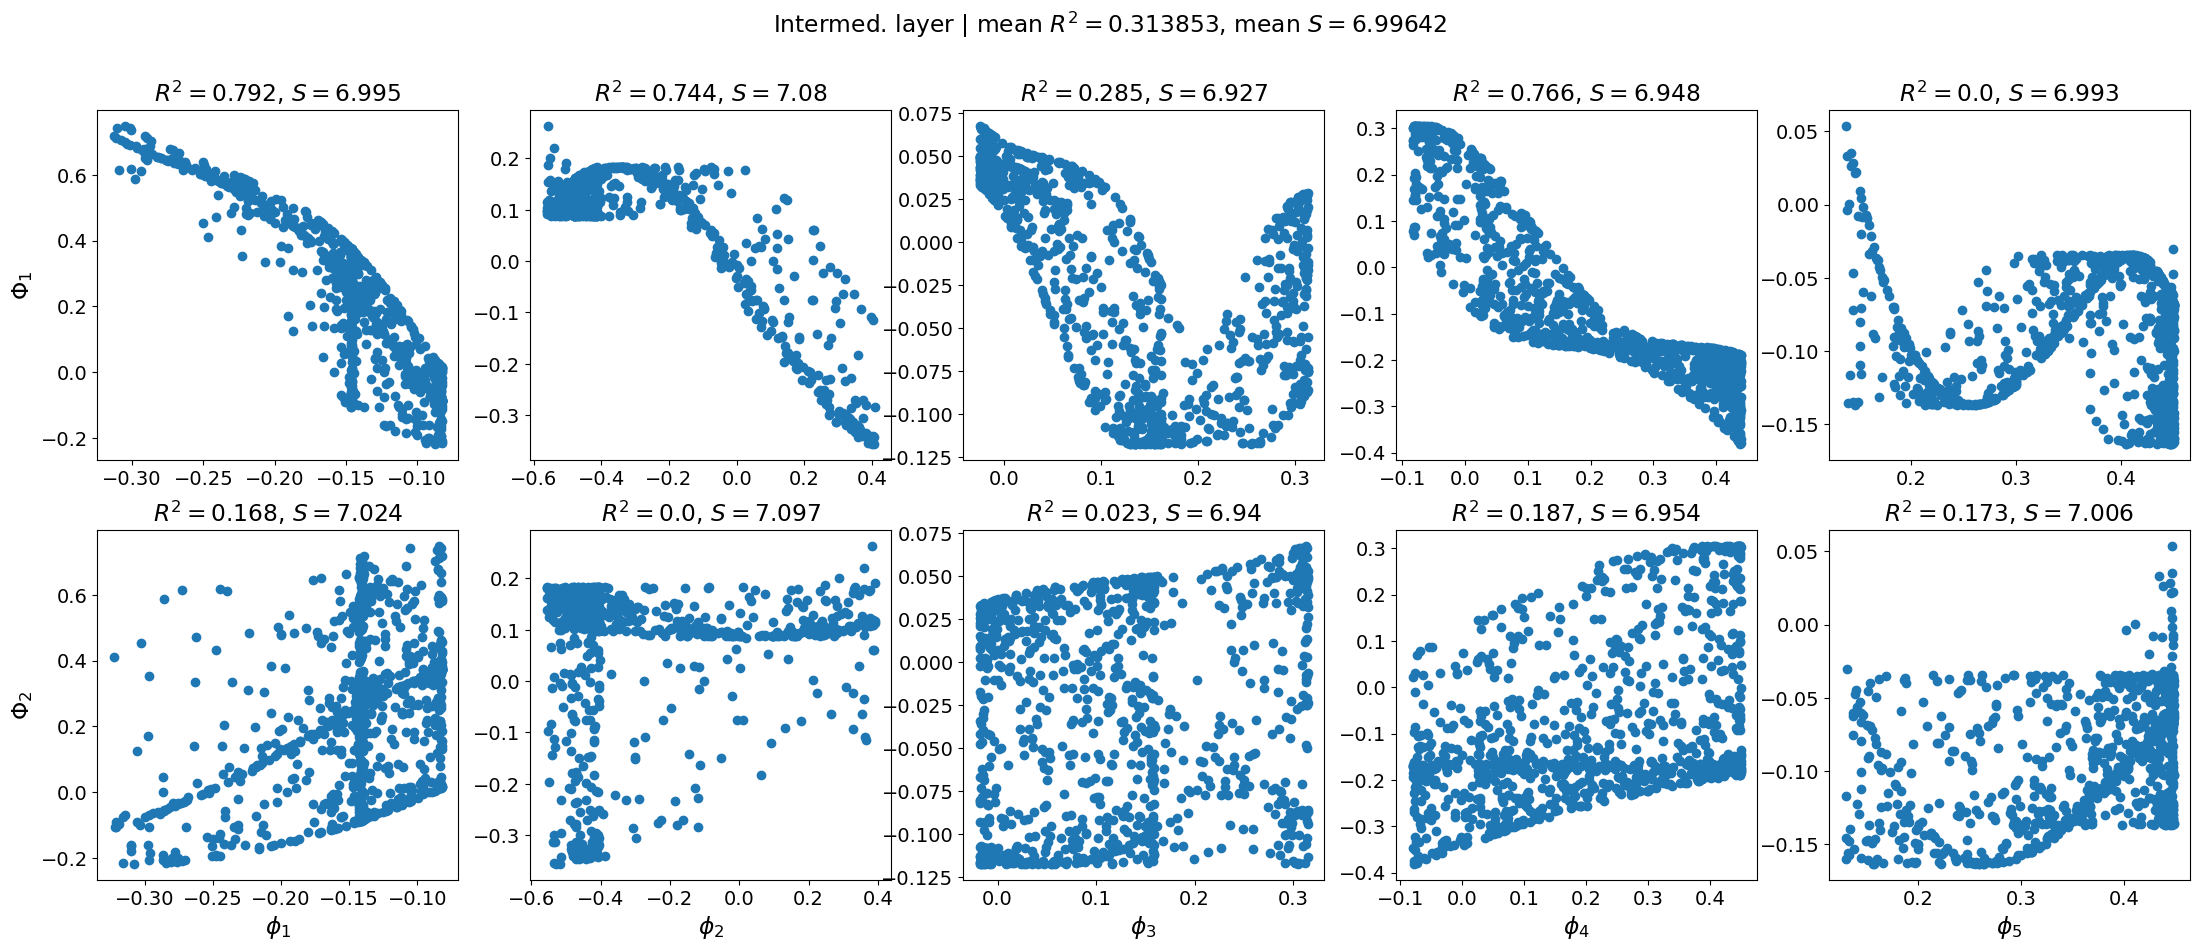

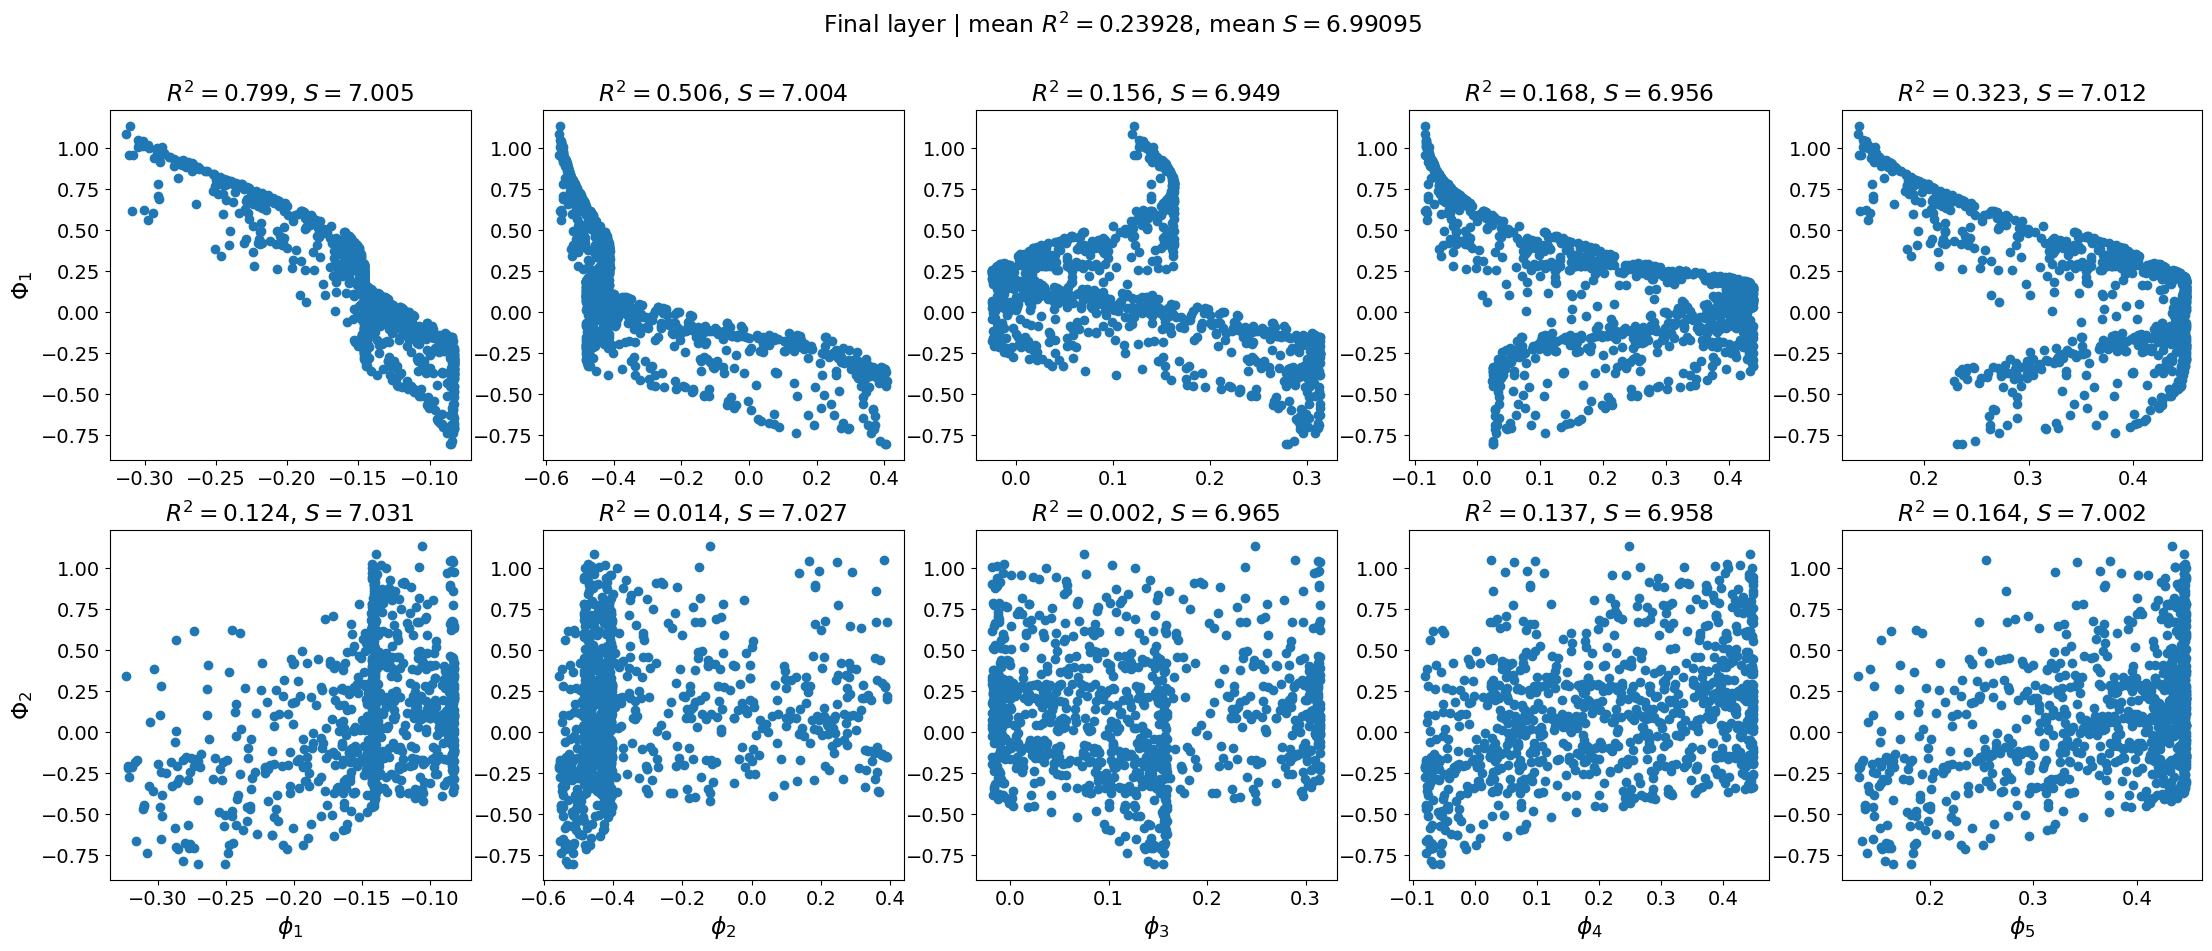

{'mean_r2': 0.23927995741833002, 'mean_matrix_entropy': 6.990950107574463}

In [73]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
-----
### $\lambda$-KAN with __R2 regression__ in respect to __Final activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 142


| train_loss: 3.20e-02 | test_loss: 3.41e-02 | reg: 7.28e+00 | : 100%|█| 150/150 [01:23<00:00,  1.81


saving model version 0.1


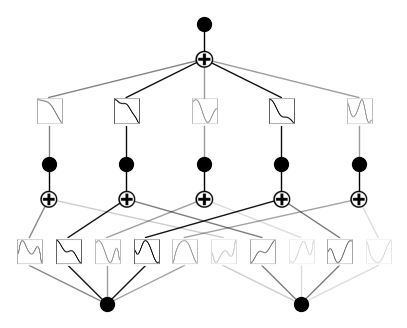

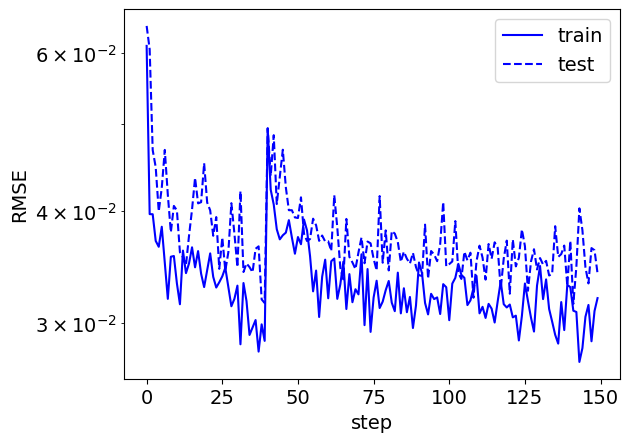

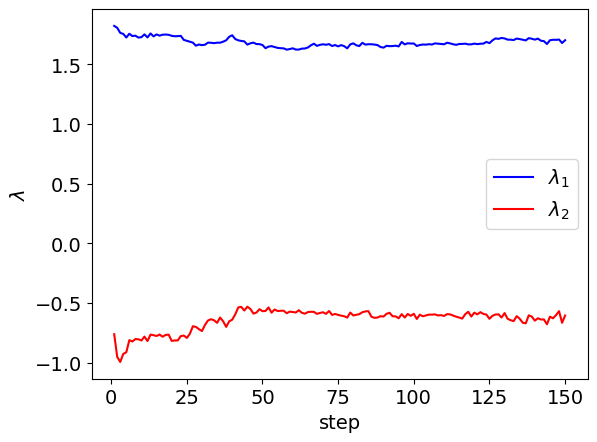

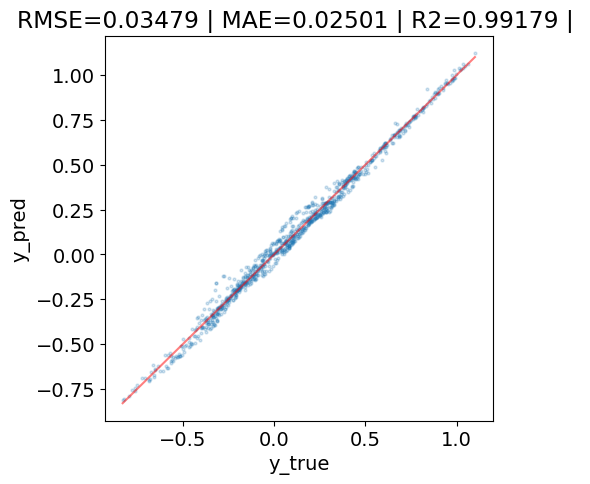

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.7028, -0.6051], requires_grad=True)


In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=1.0, reg_type='r2',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:14, 22.68it/s]                         


module of Input importance:


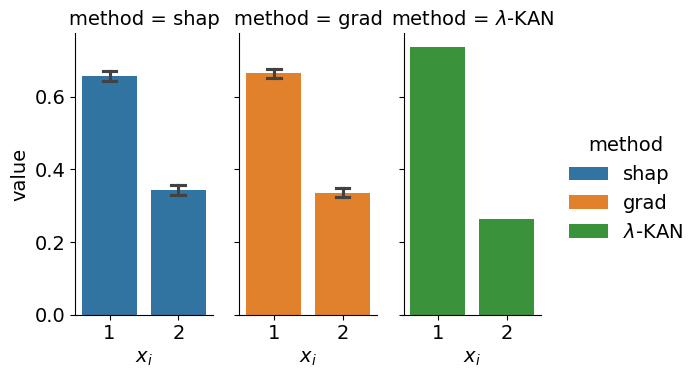

Input importance:


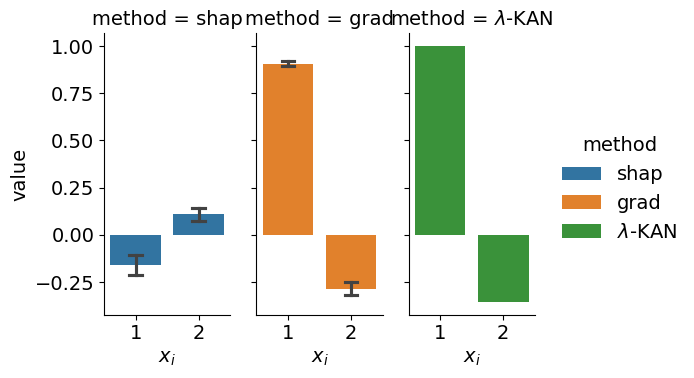

In [ ]:
importance_analyse_lmdKAN(model, dataset)

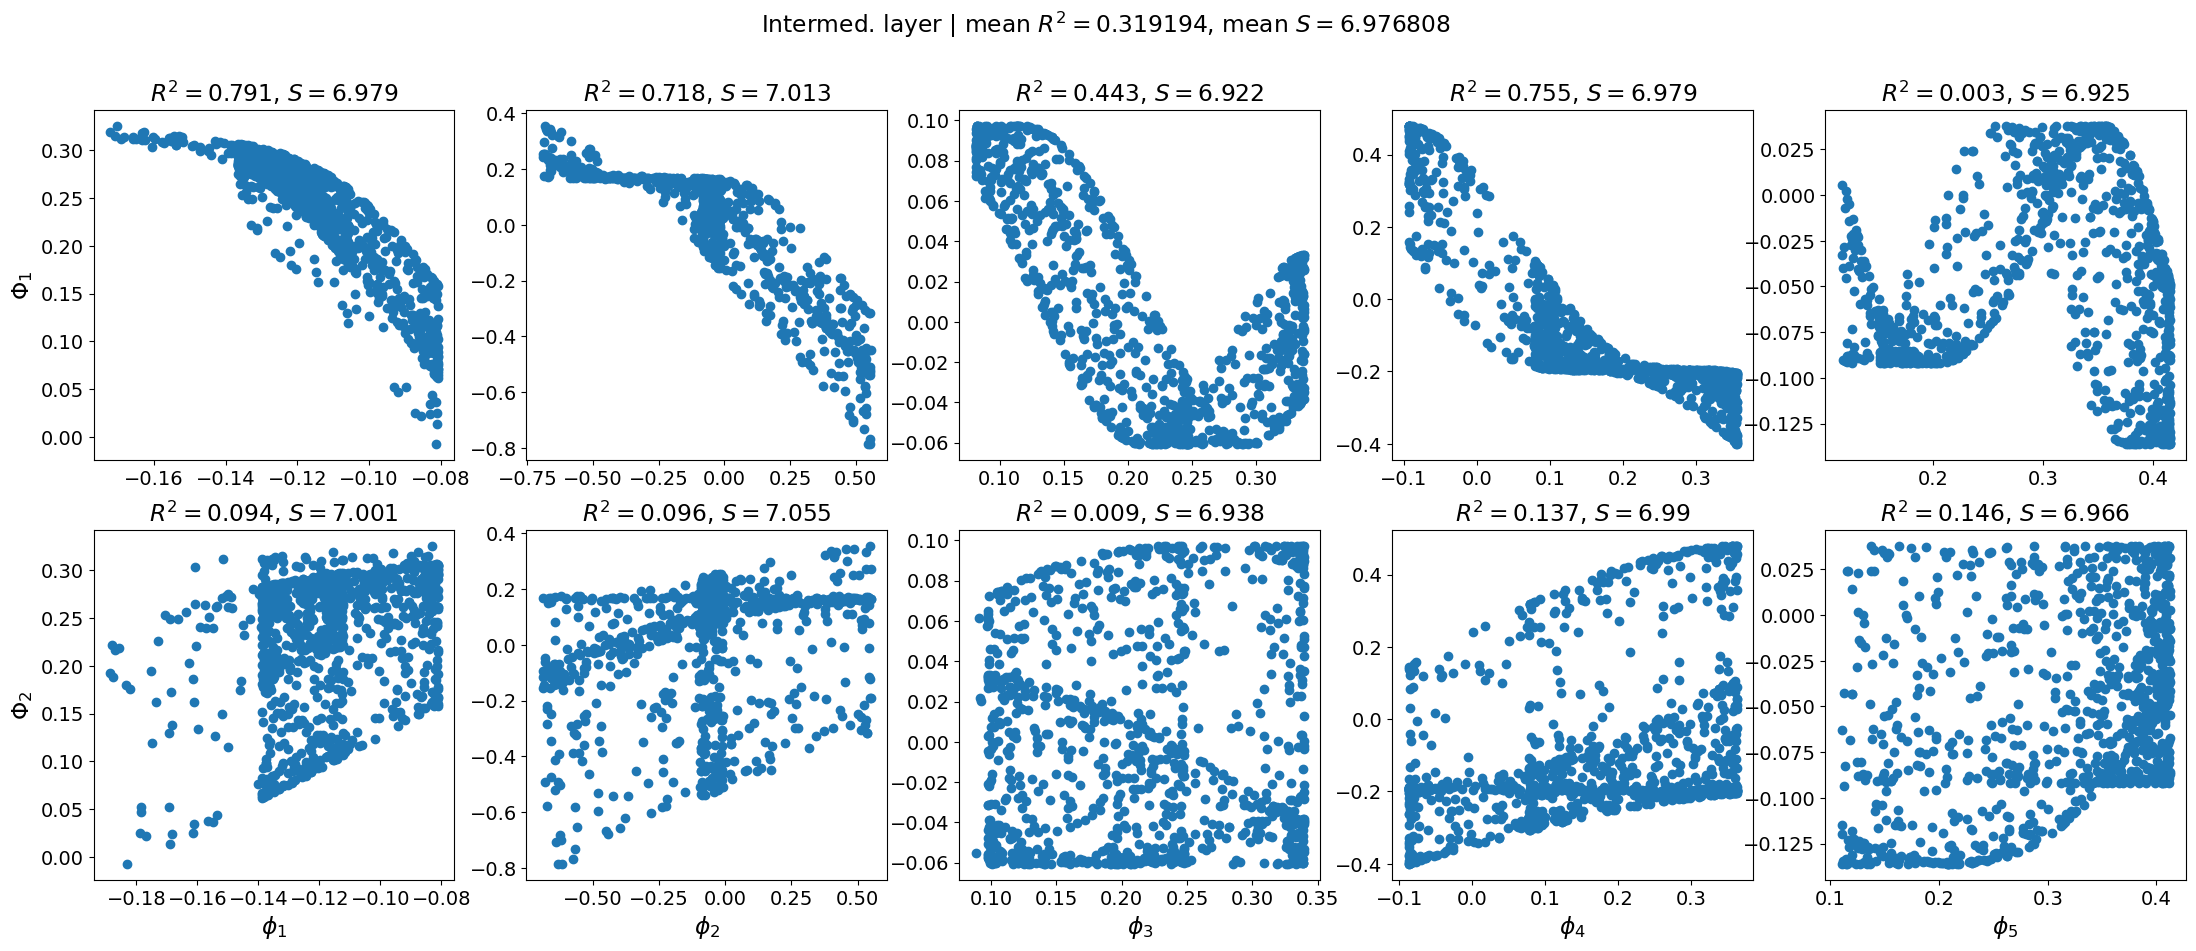

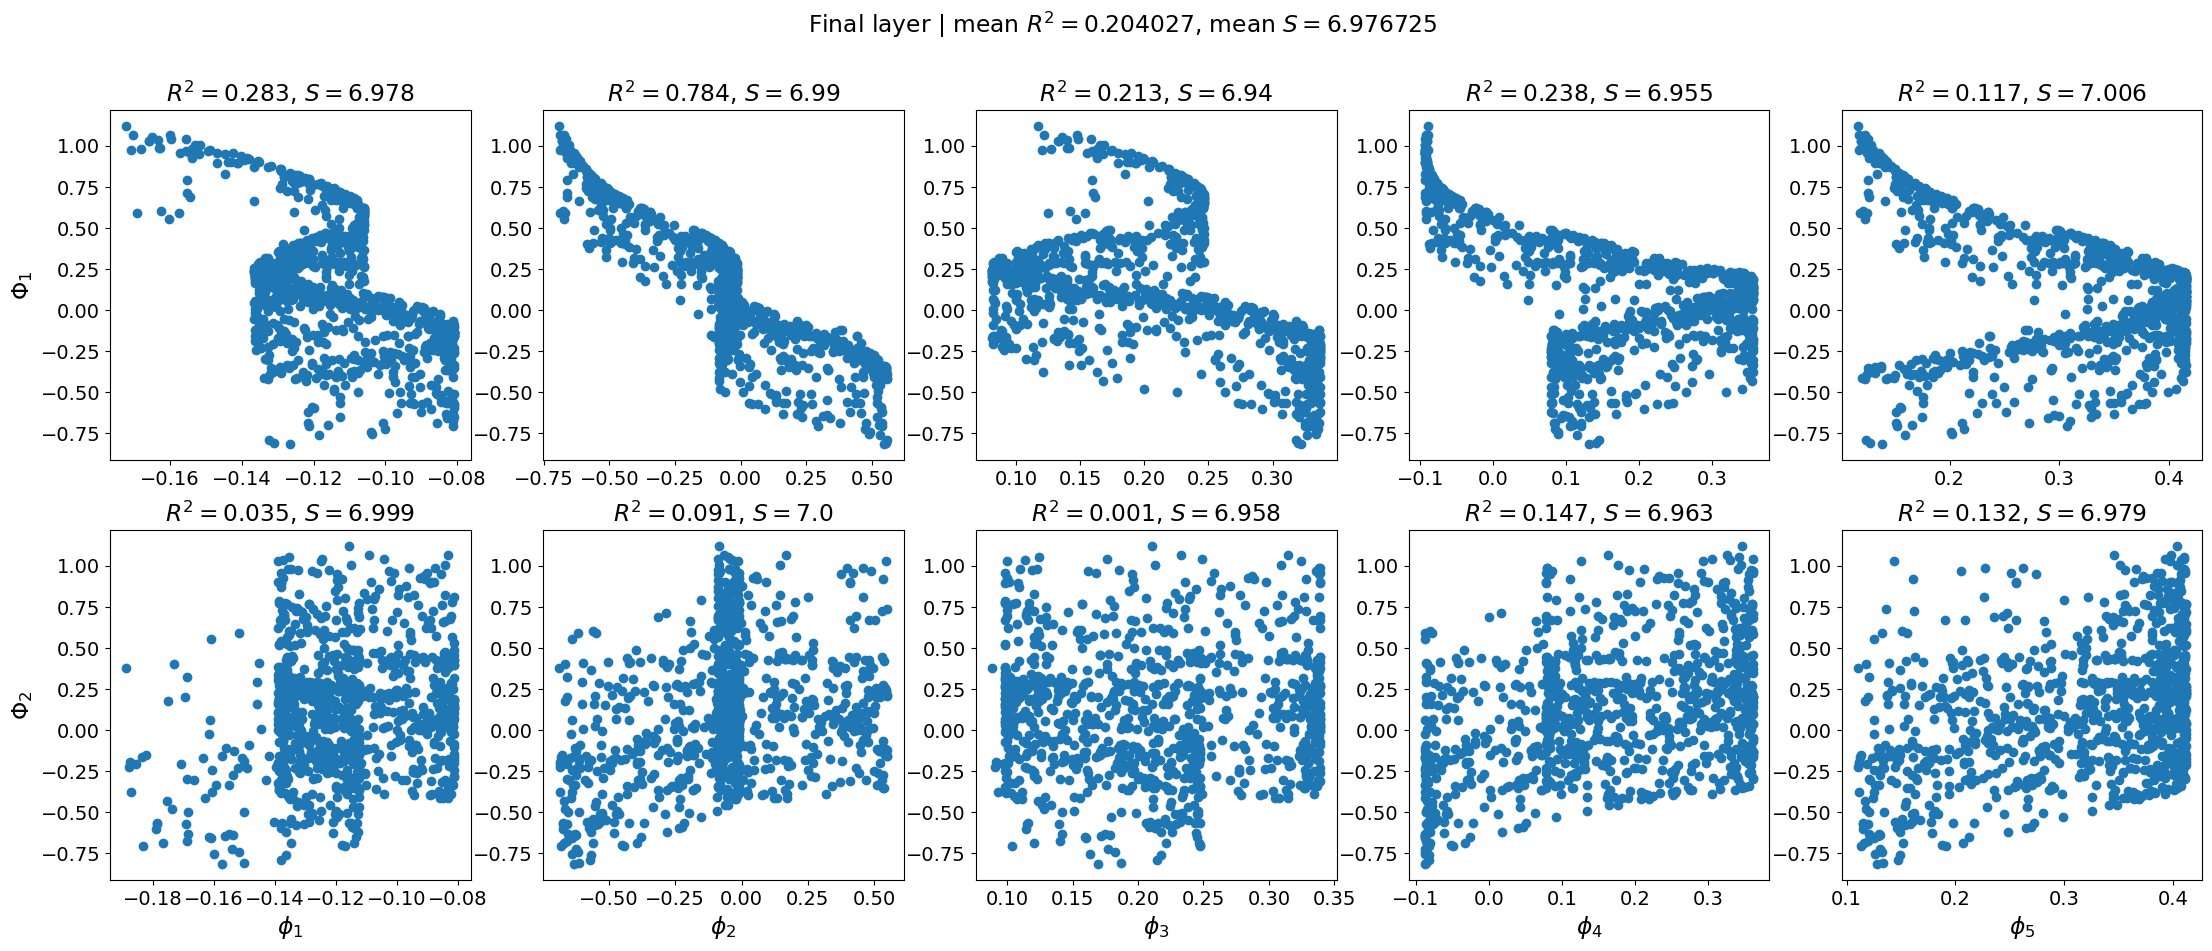

{'mean_r2': 0.20402672272757627, 'mean_matrix_entropy': 6.976725101470947}

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
### $\lambda$-KAN with __Entropy regression__ in respect to __Final activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 142


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 2.41e-02 | test_loss: 2.62e-02 | reg: 6.76e+00 | : 100%|█| 150/150 [01:50<00:00,  1.36


saving model version 0.1


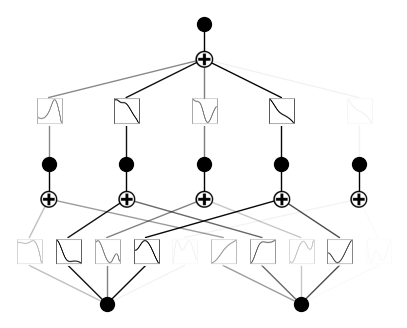

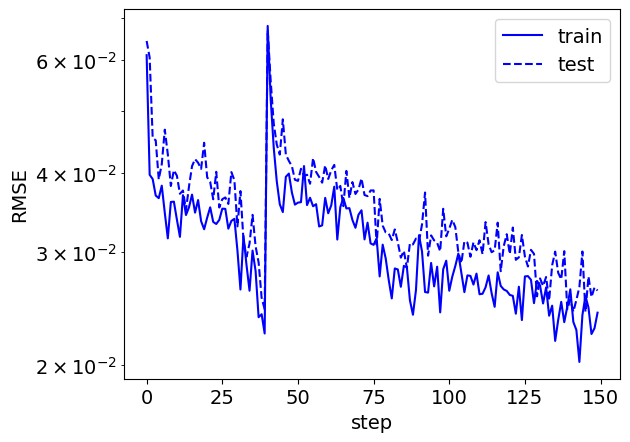

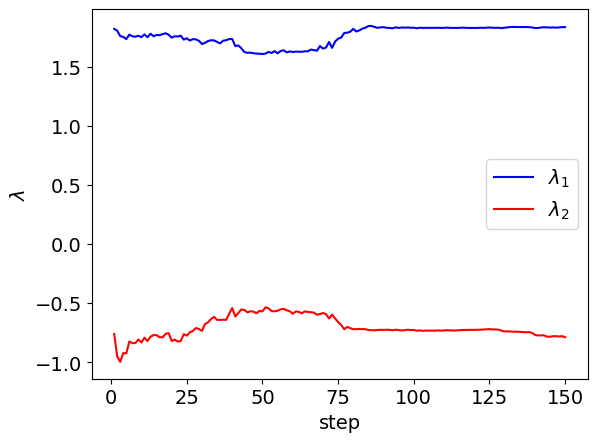

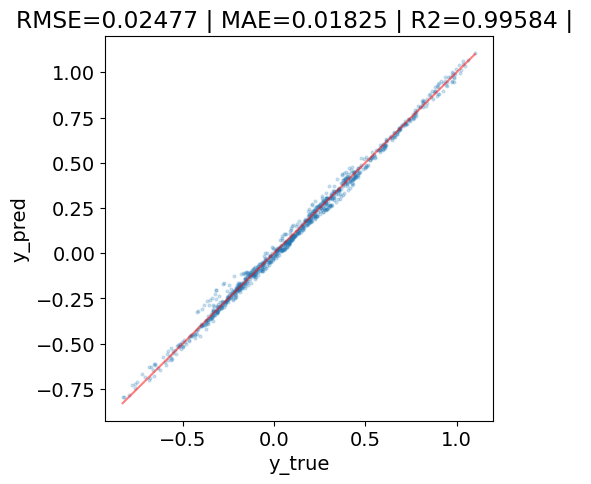

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.8371, -0.7889], requires_grad=True)


In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=1.0, reg_type='entropy',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:17, 27.37it/s]                         


module of Input importance:


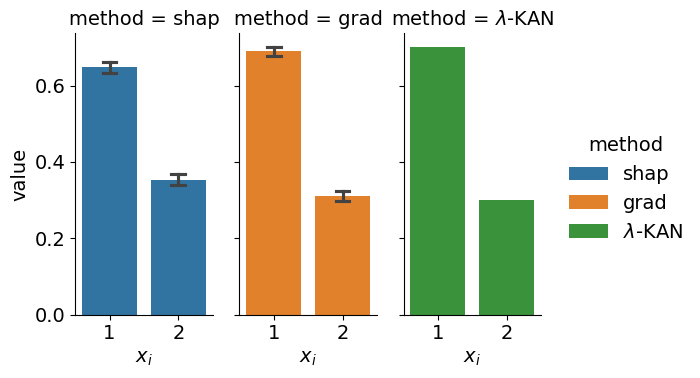

Input importance:


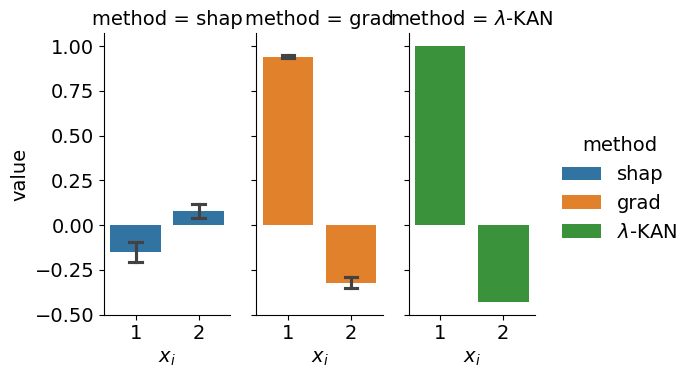

In [ ]:
importance_analyse_lmdKAN(model, dataset)

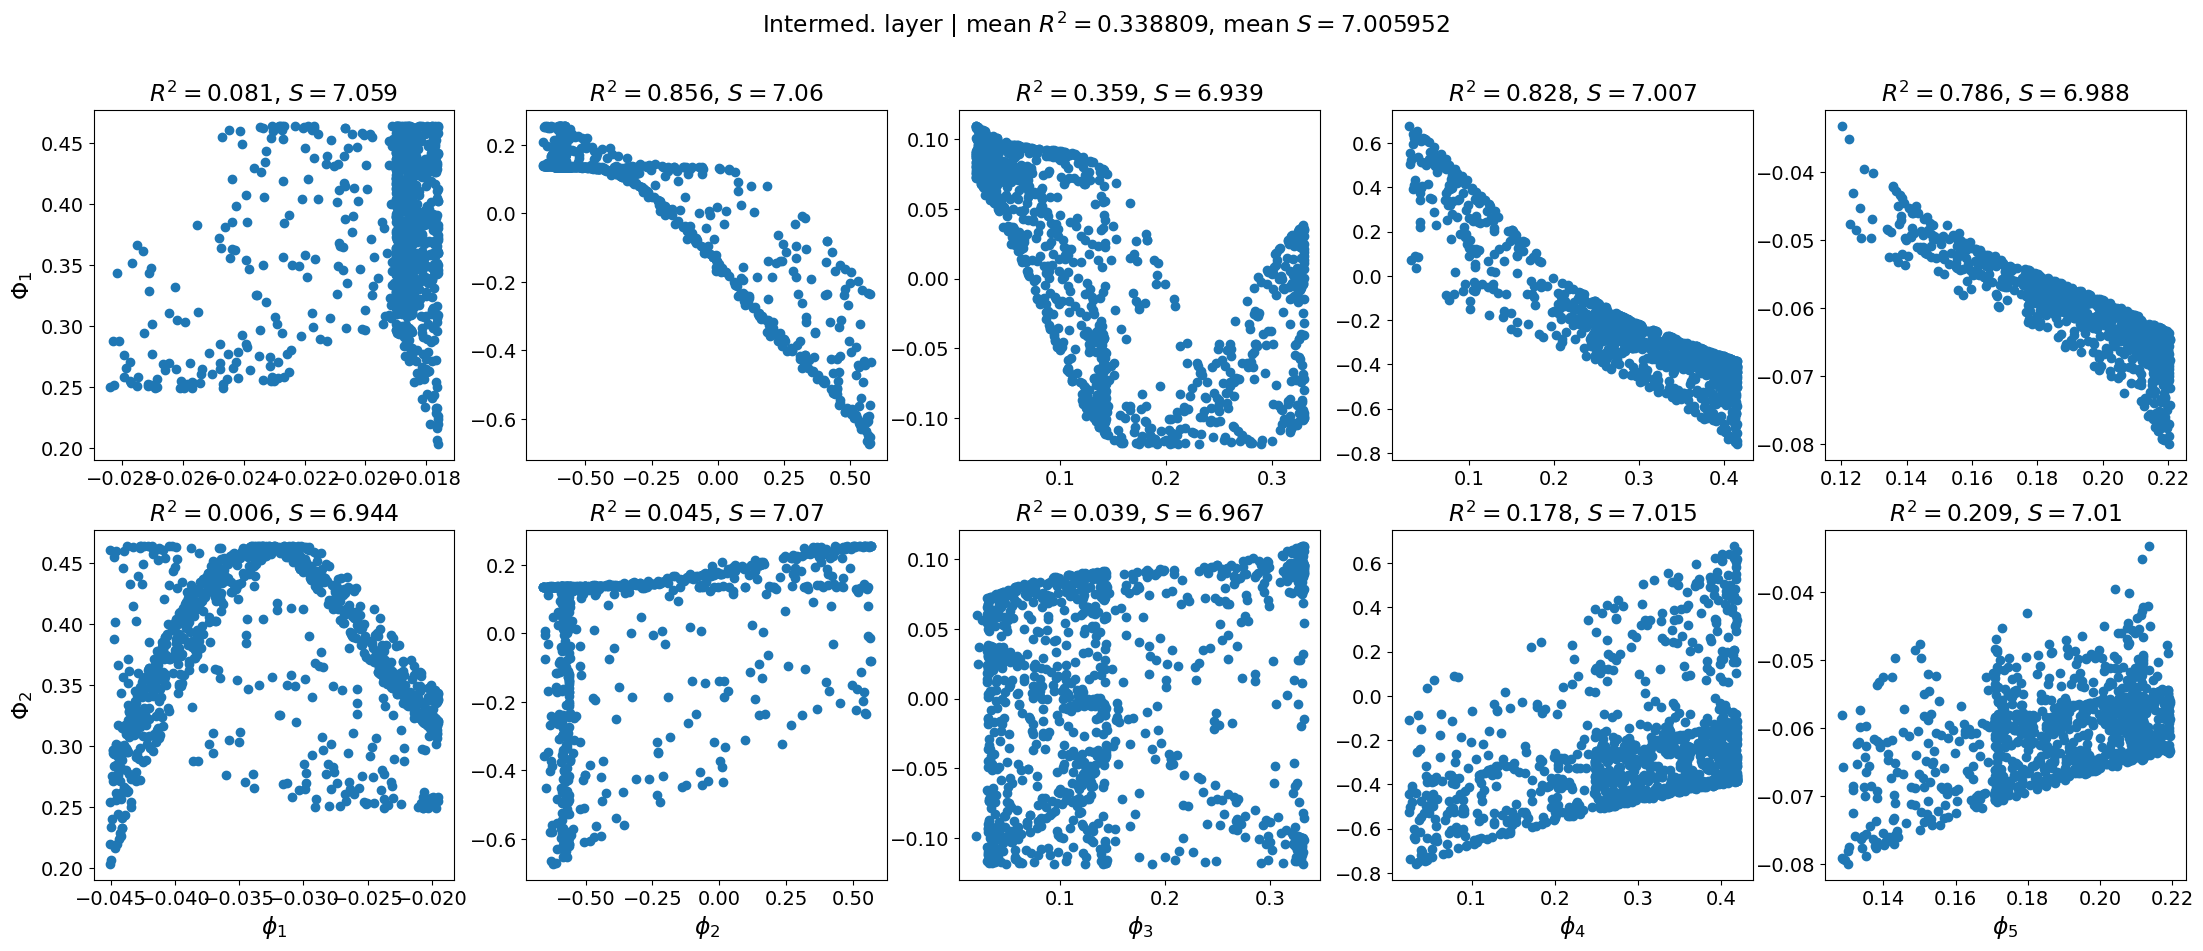

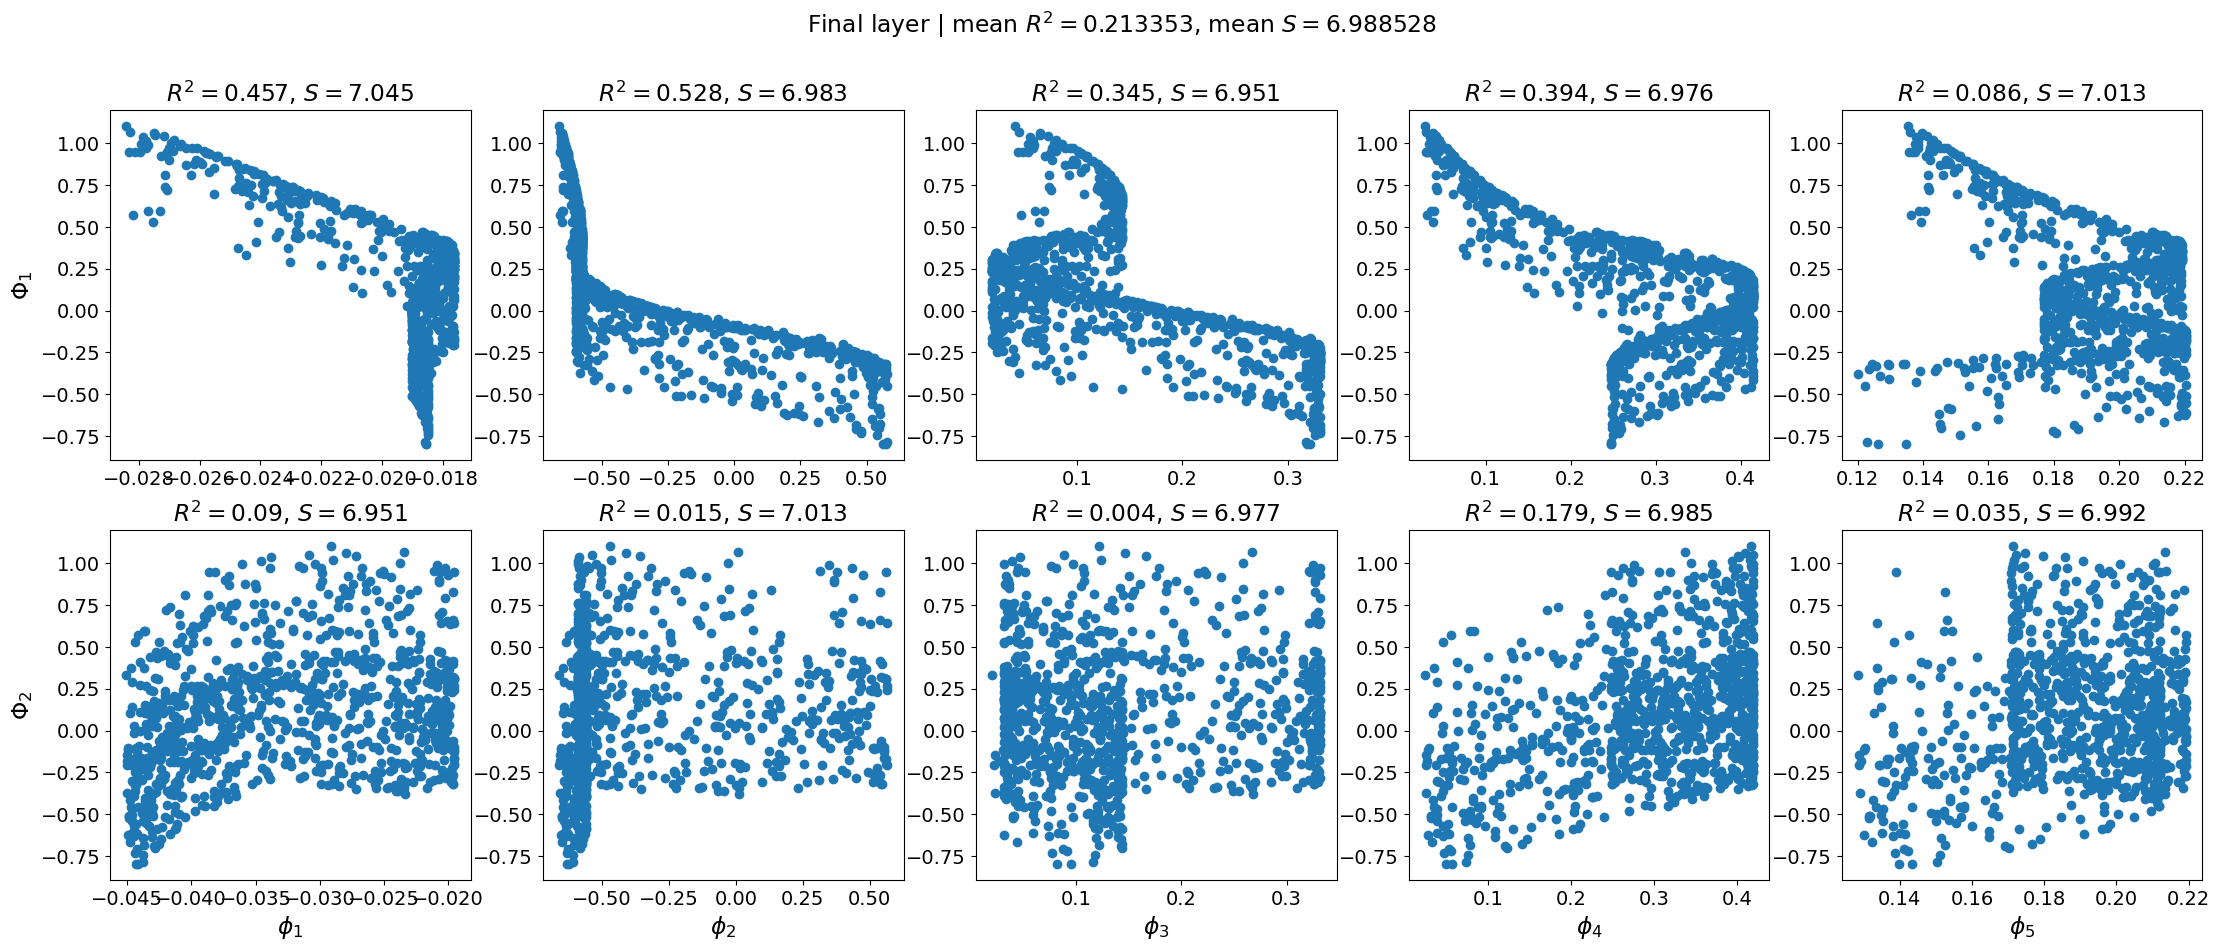

{'mean_r2': 0.21335328000131995, 'mean_matrix_entropy': 6.988528251647949}

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')